#### _Speech Processing Labs 2020: Signals: Module 2_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from dspMisc import *

# 3 Impulse Source, IIR Filter

### Learning Outcomes
* Be able to explain the difference between an FIR and an IIR filter
* Understand that IIR filters can be applied to impulse trains to produce different spectral envelopes

### Need to know
* Topic Videos: Impulse Response, Source Filter Model
* [Building the source: impulse trains](sp-m2-1-impulse-as-source.ipynb)
* [FIR filters](sp-m2-2-fir-filters.ipynb)

<div class="alert alert-warning">
<strong>Equation alert</strong>: If you're viewing this on github, please note that the equation rendering is not always perfect. You should view the notebooks through a jupyter notebook server for an accurate view.
</div>


## 3.0 Filters again

The previous notebook explored Finite Impulse Response (FIR) filters which took a 
 an input sequence $x[n]$ to give us some desired output sequence $y[n]$.  We saw that these FIR filters basically applied a weighted average across the input sequence and that this could be characterised in terms of convolution. 
Now, we'll look at Infinite Impulse Response (IIR) filters, which allow us to model more complex feedback behaviour that's closer to what we might expect from the vocal tract.

## 3.1 Definition of an Infinite Impulse Response filter

Unlike FIR filters, IIR filters use outputs from previous time steps to calculate the next output. 

$$ y[n] = \sum_{k=0}^N b[k] x[n-k] + \sum_{k=0}^M a[k] y[n-k]$$

The 'infinite' in the name comes from the fact that you can define a filter in this way so that a single impulse results in an infinitely long non-zero output sequence.  

For example

$$ y[n] =  x[n] + y[n-1] $$  

if $x[n] = 1$ for $n=1$ and 0 otherwise, then 

* $ y[1] = 1 + 0  = 1$
* $ y[2] = 0 + 1 = 1$ 
* $ y[3] = 0 + 1 = 1$  

i.e. $y[n] = 1$ for all $n$ to infinity! 

These can be much more efficient than using an FIR filter: we can get the same effect with fewer parameters. (e.g. in some cases you can define a 4th order FIR filter that does the same job as a 19th order FIR filter). The flip side is that they're harder to analyze. 

Unfortunately, there's no direct way to compute the a(k)'s and b(k)'s from the impulse response for an IIR filter, but we can use the **z Transform** to do this (we won't go into it in this class).  Instead we'll focus on how we can use an IIR filter to create a speech shaped sound.  

## 3.2 Using an IIR filter to shape the spectral envelope

### Let's start with an impulse train

Text(0.5, 1.0, 'An impulse train')

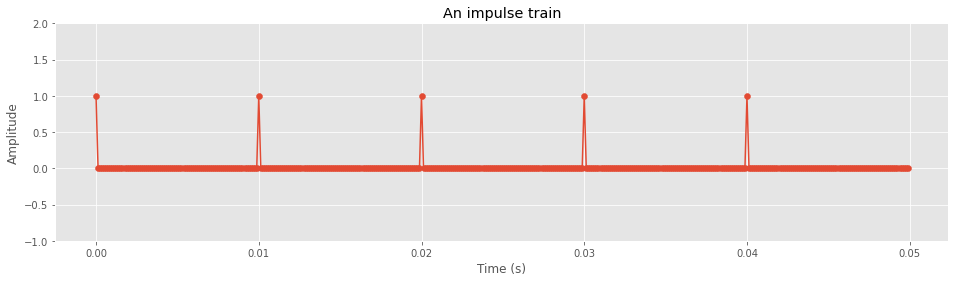

In [2]:
N=400
f_s = 8000
t_s = 1/f_s

## Set the impulse train frequency in Hz
frequency = 100

## Generate N samples of an impulse train with frequency=frequency given a sampling rate of f_s
x_imp, time_steps = make_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)

## plot and label
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(ylim=(-1, 2))
ax.scatter(time_steps, x_imp)
ax.plot(time_steps, x_imp)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("An impulse train")

### Now let's define a function to calculate the output of an IIR filter given feedback coefficients `a` and feedforward coefficients `b`.

In [3]:
# iir_filter applies the IIR filter defined by feedforward coefficients, b, and feedback coefficients, a,
# where the coefficients are input as ordered lists
def iir_filter(x, a=[], b=[]):
    
    ## Get the size of the input
    ## Note the size of N will depend on how we deal with edge cases

    N = len(x)
    
    ## Initialize our output array, y, to all zeros
    y = np.zeros(N)   
   
    ## step through each input index n
    for n in range(N):
        y[n] = 0

        ## get the contribution from the inputs
        for k in range(len(b)):
            if n-k >= 0: 
                ## multiply the previous inputs with filter coefficients, b, and add them up
                ## just like an FIR filter
                y[n] = y[n] + (b[k]*x[n-k])

        
        ## get contribution from the existing outputs        
        for l in range(len(a)):
            ## Note: We don't want to include the current output in this calculation! 

            if n-l > 0:  
                ## multiply the previous outputs with filter coefficients, a, and add them up
                y[n] = y[n] + (a[l]*y[n-l-1])

    return y    


    

### Apply the IIR filter to our impulse train


In [4]:
## An impulse train with amplified impulse to make things easier to see. 
## It doesn't change the shape of the frequency response
x = x_imp * 10

## Note coefficients opposite sign to what Simon has in his slides.  Maybe a matlab thing? 
## Or a notation thing to make transfer function look nicer? 
a = [3.22666099, -4.3967485, 3.03596532, -0.88529281]
b = [1]

## You might like to try this Low pass filter from Lyon's DSP textbook
#a=[1.194, -0.436]
#b=[0.0605, 0.121, 0.0605]

y_iir = iir_filter(x, a=a, b=b)


### Plot the filtered output in the time domain

400 92.90359312571272


Text(0.5, 1.0, 'Impulse train transformed by an IIR filter')

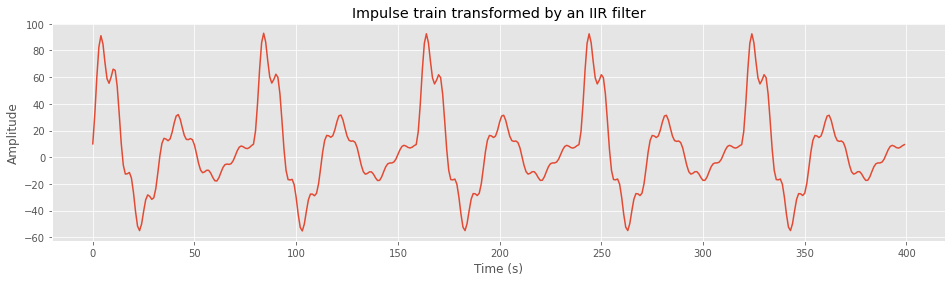

In [5]:
## Plot the filtered output
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(N), y_iir)
print(N, np.max(y_iir))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Impulse train transformed by an IIR filter")

## Starting to look more speech...ish

Now we're starting to make something that looks like a speech waveform! 

### Now let's look at the DFT of the filter's output

Text(0.5, 1.0, 'Frequency response of IIR filter output (sample rate: 8000 samples/sec)')

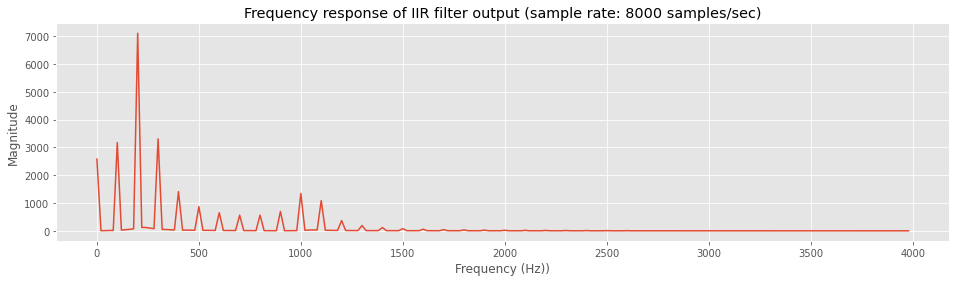

In [6]:
## Get the DFT outputs of the IIR filter's output
mags, phases = get_dft_mag_phase(y_iir, N)

## Plot the DFT frequencies rather than DFT output indices
dft_freqs = (f_s/N) * np.arange(N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])
ax.set_xlabel("Frequency (Hz))")
ax.set_ylabel("Magnitude")
ax.set_title("Frequency response of IIR filter output (sample rate: %d samples/sec)" % f_s)




### Exercise

* What happens to the filtered signal if we alter the filter coefficients:
    * Try out the filter coefficients in the cell below and describe what sort of effect they have.  
    * What sort of frequencies do they boost and which do they dampen? 
    * Do any look like low-pass or high-pass filters, for example?
    * Do all of them produce outputs that look like vocal pulses? 

* If you play around the coefficients it's quite easy to end up with an output that doesn't 'fade out' over time.  What happens to the DFT in this case?  


In [7]:
## Try out these different sets of IIR filter coefficients
## ex 1
a = [0.8]
b = [1]

## ex 2
a = [-0.8]
b = [1,-1]

## ex 3:
a = [0.566, -0.16017]
b = [1, 1.414, 1]

## ex 4: 
a = [0.566, -0.16017]
b = [1, 0.414, -0.414, -1]

## ex 5:
a = [1.272, -0.80899]
b = [1, 0.414, -0.414, -1]

## ex 6: unstable (unbounded) but still gives us a frequency response like the one previous
a = [1.554, -1.207]
b = [1, 0.414, -0.414, -1]



Text(0.5, 1.0, 'Frequency response of IIR filter output: a=[0.8], b=[1]')

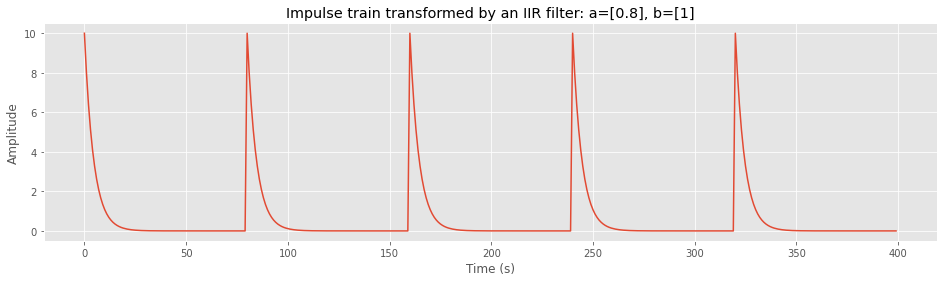

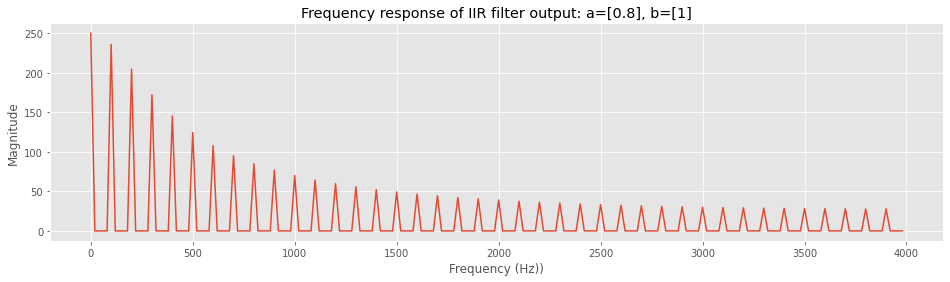

In [8]:
## set which coeffients you want to use here. 
## e.g. ex 1
a = [0.8]
b = [1]

## the impulse train
x = x_imp * 10
y_iir = iir_filter(x, a=a, b=b)

## Plot the filtered output
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(N), y_iir)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Impulse train transformed by an IIR filter: a=%s, b=%s" % (repr(a), repr(b)))

#print(N, np.max(y_iir))


## Plot the DFT frequencies rather than DFT output indices
mags, phases = get_dft_mag_phase(y_iir, N)
dft_freqs = (f_s/N) * np.arange(N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
#ax.scatter(dft_freqs[0:int(N/2)],mags[0:int(N/2)])
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])
ax.set_xlabel("Frequency (Hz))")
ax.set_ylabel("Magnitude")
ax.set_title("Frequency response of IIR filter output: a=%s, b=%s" % (repr(a), repr(b)))





### Notes

---

## 3.3 (Optional Extras) Designing a filter using poles and zeros

<div class="alert alert-warning">
<em>This section is very much optional extension. The following gives a very, very terse overview of how you can design an IIR filter frequency response using the concept of poles and filters. This requires a fair grip on solving polynomials and complex numbers, but once you've got that it's actually quite nice! 
    
If you're interested in learning more about this (or signal processing in general), it's probably time to pick up a Digital Signal Processing textbook. Rick Lyon's [Understanding Digital Signal Processing](https://www.dsprelated.com/books/6.php) is probably the most accessible I've come across. The example filters above were taken from that book. The end of this section basically gives a excessively detailed derivation going from poles and filters to coefficients for those examples. 

Previous SLP students have also recommended [The Scientist and Engineer's Guide to
Digital Signal Processing](http://www.dspguide.com/pdfbook.htm), though the free online version renders a bit weirdly!. 
</em>
</div>

IIR filters have the following form: 

$$ y[n] = \sum_{k=0}^N b(k) x[n-k] + \sum_{k=0}^M a(k) y[n-k]$$

Unlike an FIR filter, we can't just put an impulse in and find out what the frequency response of the filter is.  Instead, to understand the properties of an IIR filter, we use the **z-transform**.  The z-transform is the discrete version of the continuous Laplace transform.  We won't get into the details here, but if you do read more about this you'll see that you can think of the Laplace transform as a generalization of the Fourier Transform. So the intuitions you've developed about how the Fourier Transform works (e.g. finding correlations between inputs and basis functions) will help understand the Laplace Transform too.

We use the z-transform to convert filter difference equations to an equivalent form in the z-domain (z being a complex number).  We rewrite our difference equation in terms of the z-transformed input $x[n]$ and output $y[n]$ functions, which we denote as $X(z)$ and $Y(z)$ respectively.  Some algebra then allows us to define a **transfer function** $H(z)$: 

$$ Y(z) = H(z)X(z)$$

So, $H(z)$ is what our filter does to our input to get our output in the z-domain. You can think of it as the filter part of the source filter model (the source being our impulse train and/or white noise).  

Unsurprisingly, we can actually define $H(z)$ in terms of our the feedforward coefficients $b(k)$ and the feedback coefficients $a(k)$. What's surprising is that we can define it in a relatively simple way: 


$$ H(z) = \frac{Y(z)}{X(z)} = \frac{\sum_{k=0}^N b(k)z^{-k}}{1- \sum_{k=1}^M a(k)z^{-k}}\\ $$

You can think of  $z^{-k}$ as referring to a position in the sequence $k$ steps back in time.

We can analyze $H(z)$ to figure out how the filter is going to behave. To do this we need to factorize the numerator and denominator polynomials of $H(z)$.

$$ 
\begin{align}
H(z) &= \frac{\sum_{k=0}^N b(k)z^{-k}}{1- \sum_{k=1}^M a(k)z^{-k}}\\
&= G\frac{(z-z_0)(z-z_1)...(z-z_N)}{(z-p_0)(z-p_1)...(z-p_M)} 
\end{align}
$$

In the equation above, $G$ is an arbitrary gain constant which doesn't affect the frequency response or filter stability. The polynomial roots, $z_n$ and $p_m$ are called *zeros* and *poles* respectively.  These are the (complex) values of $z$ which cause the numerator (zeros) or the denominator (poles) to equal 0.  We can interpret them as follows:   

* **Zeros:** when the numerator goes to zero, the transfer function $H(z)$ goes to zero, and we see decrease (attenuation) in the frequency magnitude response. 
* **Poles:** when the denominator goes to zero, the transfer function $H(z)$ goes to infinity, leads to an increase (gain) the frequency magnitude response (like vowel formants!)

It may not look like it right now, but it's way easier to analyze IIR filters in the z-domain than in the time domain! Once we know the poles and the zeros of the transfer function, we basically know what the frequency response will look like and whether the filter is stable or not.  The main things to note are: 

* If a pole falls inside the unit-circle (of the complex z-plane), the filter output will be **stable**.  
    * Given an impulse input, $y[n]$ it will eventually go to zero as $n$ increases. 
* If a pole falls outside the unit circle, the output will be **unstable**
    * Given an impulse input, $y[n]$ will keep increasing in magnitude as more time passes (definitely not the behaviour of the vocal tract!). 
* If a pole lies exactly on the unit circle, the output will oscillate between finite values determined by the pole locations forever.

An IIR filter is only as stable as it's weakest link - if any poles sit outside the unit circle, the filter as a whole will be unstable.  Zeros don't affect filter stability. 

Another property of poles (and zeros) is that, if the denominator polynomial has real-valued coefficients (i.e. the $a(k)$ values), poles (and zeros) either come in pairs of complex conjugates (i.e. if $p=a+ib$ is a pole, so is $p^*=a-ib$), or it's a value on the real axis of the z-plane.  We can use these facts to design filters using the factorized form of the transfer function, which will then allow us to derived the filter coefficients $a(k)$ and $b(k)$. We'll see some examples this below. 

The frequency response of the filter is $H(z)$ evaluated at $e^{j\omega}$, where $-\pi \lt \omega \lt \pi$ represents frequencies in terms of radians per sample ($\pi$ radians/sample $\mapsto$ a frequency matching half the sampling frequency (i.e. $f_s/2$). 

$$ H(\omega) = H(e^{j\omega}) = \frac{\sum_{k=0}^N b(k)e^{-jk\omega}}{1 -\sum_{k=0}^M a(k)e^{-jk\omega}} $$


These example IIR filters from Richard J Lyon's book 
[Understanding Digital Signal Processing](https://www.dsprelated.com/books/6.php), which is a very nice introduction to the topic.

Working through from the factorized form to the coefficients is not hard, but it is very annoying and it's very easy to make mistakes, so I've given all the steps expanding out the factorized forms of the filter examples he gives in his book below. 



### Ex 1: 


$$
\begin{aligned}
H_1(z) &= \frac{G}{z-0.8}\\
       &= G\frac{1}{1-(0.8z^{-1})} 
\end{aligned}
$$


* One pole on the real axis, inside the unit circle, stable peak at $\omega=0$ rad/sample  
* no zeros



In [ ]:
a = [0.8]
b = [1]

### Ex 2: 

$$
\begin{aligned}
H_1(z) &= G\frac{(z-1)}{z-(-0.8)}\\
       &= G\frac{1 - z^{-1}}{1 -  (-0.8z^{-1})}
\end{aligned}
$$


* pole on real axis at -0.8, inside the unit circle, stable peak at $\omega=-\pi$ rad/sample, i.e. $f_s/2$ Hz which is 8000/2 = 4000 Hz in our setup above. 
* one zero at z=1, this causes attenuation at $\omega = 0$ rads/sample (0 Hz)

In [ ]:
a = [-0.8]
b = [1,-1]

### Ex 3
$$
\begin{align}
H_3(z) &= G\frac{[z-(-0.707 + j0.707)][z-(-0.707 - j0.707)]}{[z-(0.283+j0.283)][z-(0.283-j0.283)]} \\
&= G\frac{z^2 -z(-0.707 - j0.707) - z(-0.707 + j0.707) + (-0.707 + j0.707)(-0.707 - j0.707) }{z^2 - z(0.283-j0.283) -z(0.283+j0.283) + (0.283+j0.283)0.283-j0.283)} \\
&= G\frac{z^2 +z0.707 + j0.707z + z0.707 - j0.707z + 1 }{z^2 - 0.283z + j0.283z - 0.283z - j0.283z + 0.16017} \\
&= G\frac{z^2 +z[0.707  + 0.707] + 1 }{z^2 - 0.283z - 0.283z  + 0.16017} \\
&= G\frac{z^2 + 1.414z + 1 }{z^2 - 0.566z + 0.16017} \\
&= G\frac{1 + 1.414z^{-1} + 1z^{-2} }{1 - 0.566z^{-1} + 0.16017z^{-2}} \\
\end{align}
$$

* The poles are inside the unit circle, this produces a low pass filter  (pass band is 'bordered' by +/- $\omega = \pi/4$ rad/sample, 1000 Hz) 
    * $(0.283+j0.283) \mapsto 0.400e^{j\pi/4}$
* zeros on the unit circle, attenuation at $3\pi/4$ rad/sample = 3000 Hz.
    * $(-0.707+j0.707) \mapsto 1e^{j3\pi/4} $ 

In [ ]:
a = [0.566, -0.16017]
b = [1, 1.414, 1]


### Ex 4: 
$$
\begin{align}
H_4(z) &= G\frac{[z-1][z-(-0.707 + j0.707)][z-(-0.707 - j0.707)]}{[z-(0.283+j0.283)][z-(0.283-j0.283)]} \\
&= G\frac{[z-1] [z^2 + 1.414z + 1] }{z^2 - 0.566z + 0.16017}\\
&= G\frac{z^3 + 1.414z^2 + 1z -z^2 - 1.414z - 1}{z^2 - 0.566z + 0.16017}\\
&= G\frac{z^3 + 0.414z^2 - 0.414z - 1}{z^2 - 0.566z + 0.16017}\\
&= G\frac{1 + 0.414z^{-1} - 0.414z^{-2} - z^{-3}}{1 - 0.566z^{-1} + 0.16017z^{-2}}\\
\end{align}
$$

* We've added an extra zero at $z=0$ compared to example 3.  This means that we get a valley (attenuation) in the frequency response at $\omega = 0$ (0 Hz). 

In [ ]:
a = [0.566, -0.16017]
b = [1, 0.414, -0.414, -1]

### Ex 5: 
$$
\begin{align}
H_5(z) &= G\frac{[z-1][z-(-0.707 + j0.707)][z-(-0.707 - j0.707)]}{[z-(0.636+j0.636)][z-(0.636-j636)]} \\
&= G\frac{[z-1] [z^2 + 1.414z + 1] }{z^2 - 1.272z + 0.808992}\\
&= G\frac{1 + 0.414z^{-1} - 0.414z^{-2} - z^{-3}}{1 - 1.272z^{-1} +  0.808992z^{-2}}\\
\end{align}
$$

* poles are nearer to the unit circle (magnitude 0.80899), so the peaks associated with them (+/- $\omega = \pi/4$ rad/sec (1000 Hz with our sample rate) are sharper.


In [ ]:
a = [1.272, -0.80899]
b = [1, 0.414, -0.414, -1]

### Ex 6: 
$$
\begin{align}
H_6(z) &= G \frac{[z-1][z-(-0.707 + j0.707)][z-(-0.707 - j0.707)]}{[z-(0.777+j0.777)][z-(0.777-777)]} \\
&= G \frac{1 + 0.414z^{-1} - 0.414z^{-2} - z^{-3}}{1 - 1.554z^{-1} +  1.207z^{-2}}\\
\end{align}
$$

* poles are now outside the unit circle (magnitude 1.207), so the filter is now unstable: as n increases, the value of $y[n]$ eventually goes to infinity.
* It still has the same shape frequency response though! 

In [ ]:
a = [1.554, -1.207]
b = [1, 0.414, -0.414, -1]